In [11]:
# Step 1 - Import Data

In [12]:
import pandas as pd

# Load the data
cities = ['2800', '2820', '2830', '2840', '2850', '2900', '2920', '2930', '2942', '2950', '3000', '3460']
dataframes = []

for city in cities:
    filename = f'../data/house_data/house_data_{city}.csv'
    df = pd.read_csv(filename)
    df["City"] = int(city)
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

data[100:200:20]


,Address,X,Y,Price,Type,Size,Squaremeter price,Energy class,Url,City
100,Hvidegårdsparken 85,55.773286,12.529734,8495000,Villa,151,56258,C,https://www.dingeo.dk/adresse/2800-kongens%20l...,2800
120,Sophus Bauditz Vej 10,55.767861,12.481998,8250000,Villa,202,40841,E,https://www.dingeo.dk/adresse/2800-kongens%20l...,2800
140,"Lyngby Hovedgade 57B, 3. th",55.768505,12.506510,4745000,Ejerlejlighed,103,46067,E,https://www.dingeo.dk/adresse/2800-kongens%20l...,2800
160,Søager 19,55.743810,12.529096,7400000,Villa,104,71153,D,https://www.dingeo.dk/adresse/2820-gentofte/s%...,2820
180,"Søndersøvej 33A, st. mf",55.758706,12.535668,2195000,Ejerlejlighed,55,39909,C,https://www.dingeo.dk/adresse/2820-gentofte/s%...,2820


# Step 2 - Prepare data for test

In [13]:
from sklearn.preprocessing import LabelEncoder

# Remove rows containing NaN-values
data.dropna(inplace=True)

# Select relevant features
features = ['X', 'Y', 'Size', 'Type', 'Energy class', 'City']
target = 'Price'

# Preprocess the data
label_encoders = {}
for feature in features:
    if data[feature].dtype == 'object':
        label_encoders[feature] = LabelEncoder()
        data[feature] = label_encoders[feature].fit_transform(data[feature])
    print(f"{feature}: {data[feature].dtype}")






X: float64
Y: float64
Size: int64
Type: int64
Energy class: int64
City: int64


# Step 3 - Import model and run test

In [14]:
import joblib

# Load the saved model
model = joblib.load('../models/RFG_Model')

# Dataframe to store predicted results
df_results = pd.DataFrame()

# Run test on data
for idx, row in data.iterrows():

    linenumber = idx

    # Apply label encoding to the new house data 
    new_house = pd.DataFrame([[data.loc[linenumber, 'X'], data.loc[linenumber, 'Y'], data.loc[linenumber, 'Size'], 
                               data.loc[linenumber,'Type'],data.loc[linenumber, 'Energy class'], data.loc[linenumber, 'City']]], columns=features)
    
    for feature in features:
        if new_house[feature].dtype == 'object':
            new_house[feature] = label_encoders[feature].transform(new_house[feature])

    original_price = data.loc[linenumber, 'Price']
   
    # Make the prediction
    prediction = model.predict(new_house)

     # Calculate the variance
    variance = original_price - prediction

    # Calculate the variance in percent
    variance_percent = (variance / original_price) * 100


    # Create a temporary DataFrame with the current iteration's results
    temp_df = pd.DataFrame({'Predicted Price': [prediction],
                            'Original Price': [original_price],
                            'Variance': [variance],
                            'Variance %': [variance_percent]})
    
   # Concatenate the temporary DataFrame with the df_results DataFrame
    df_results = pd.concat([df_results, temp_df], ignore_index=True)
    
df_results[1:10]



,Predicted Price,Original Price,Variance,Variance %
1,[4517075.0],4495000,[-22075.0],[-0.4911012235817575]
2,[8079050.0],7695000,[-384050.0],[-4.99090318388564]
3,[5009350.0],5295000,[285650.0],[5.394711992445703]
4,[9151250.0],8750000,[-401250.0],[-4.585714285714286]
5,[4231850.0],3995000,[-236850.0],[-5.928660826032541]
6,[2074280.0],2150000,[75720.0],[3.521860465116279]
7,[2458290.0],2595000,[136710.0],[5.268208092485549]
8,[5886650.0],6195000,[308350.0],[4.977401129943503]
9,[6876400.0],5500000,[-1376400.0],[-25.025454545454544]


# Step 4 - Evaluate model performance

In [15]:
import numpy as np

mean_variance_percent = df_results['Variance %'].mean()

# Print the mean percentage variance
print("Mean Percentage Variance:", mean_variance_percent)


# Define the bin boundaries and labels
bins = [-np.inf, -50, -20, 20, 50, np.inf]
bin_labels = ['Significantly Below Average', 'Moderate Below Average', 'Close to Average', 'Moderate Above Average', 'Significantly Above Average']

# Calculate the bin counts
bin_counts = pd.cut(df_results['Variance %'], bins, labels=bin_labels).value_counts()

# Apply the binning to the 'Variance %' column
df_results['Variance Category'] = pd.cut(df_results['Variance %'], bins=bins, labels=bin_labels)

# Print the bin counts
for label, count in bin_counts.items():
    print(f"{label}: {count}")



Mean Percentage Variance: [-2.5442838]
Close to Average: 1064
Moderate Below Average: 81
Moderate Above Average: 35
Significantly Below Average: 15
Significantly Above Average: 0


# Step 5 - Plot performance

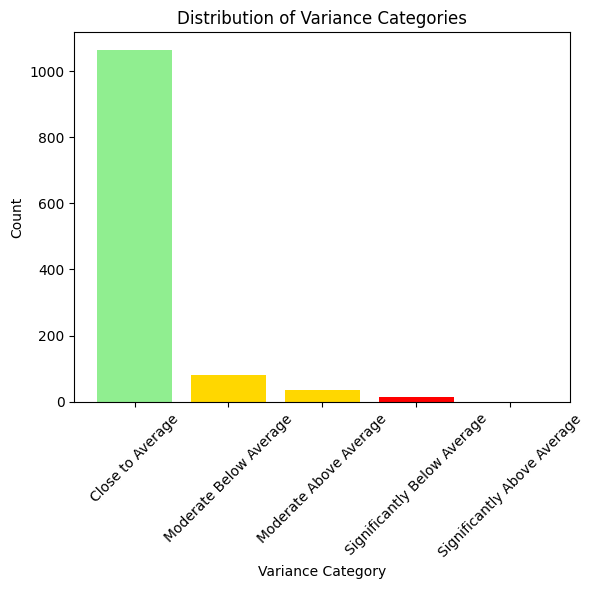

In [16]:
import matplotlib.pyplot as plt

# Define colors for each category
colors = ['lightgreen', 'gold', 'gold', 'red', 'red']

# Plot the histogram with custom colors
plt.bar(bin_counts.index, bin_counts.values, color=colors)

# Set labels and title
plt.xlabel('Variance Category')
plt.ylabel('Count')
plt.title('Distribution of Variance Categories')

# Rotate x-axis tick labels
plt.xticks(rotation=45)

# Show the plot
plt.show()